# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78701?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78753?</a></li>     
><li><a href="#q4"> 4. How is crime distributed in 78741?</a></li>
><li><a href="#q5"> 5. How is crime distributed in 78745?</a></li>
><li><a href="#q6"> 6. How is crime distributed in 78705?</a></li>
><li><a href="#q7"> 7. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q8"> 8. How is crime distributed across different districts and sectors around Austin? Location types?
><li><a href="#q9"> 9. How does violent crime appear on the map?
><li><a href="#q10"> 10. Are there any addresses where violent crime and murder occurs frequently?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("crime_reports.csv")

In [3]:
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291130 entries, 0 to 2291129
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

None

Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20831
Address                             12
Zip Code                         14067
Council District                 47068
APD Sector                        8930
APD District                      9404
PRA                              10661
Census Tract                   1528728
Clearance Status                605223
Clearance Date                  336017
UCR Category                   1510604
Category Description           1510604
X-coordinate                     10084
Y-coordinate                     10084
Latitude                         38691
Longitude                

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,20125003262,PROTECTIVE ORDER,3829,N,01/23/2012 05:17:00 AM,01/23/2012,517.0,01/23/2012 05:17:00 AM,01/23/2012,517.0,RESIDENCE / HOME,UNKNOWN,NaN,NaN,DA,1,491,NaN,N,01/23/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20072832112,ASSAULT WITH INJURY,900,N,10/10/2007 09:00:00 PM,10/10/2007,2100.0,10/10/2007 10:00:00 PM,10/10/2007,2200.0,BAR / NIGHT CLUB,HOT BODIES CLUB HWY 71 & BURLESON RD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20081232700,FAMILY DISTURBANCE,3400,N,05/02/2008 11:11:00 PM,05/02/2008,2311.0,05/02/2008 11:11:00 PM,05/02/2008,2311.0,RESIDENCE / HOME,9702 CHILSOM TRAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006900236,ASSAULT WITH INJURY,900,N,03/31/2006 02:50:00 AM,03/31/2006,250.0,03/31/2006 02:50:00 AM,03/31/2006,250.0,RESIDENCE / HOME,721 LAMAR PLACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20081002040,CRASH/FAIL STOP AND RENDER AID,3604,N,04/09/2008 07:04:00 PM,04/09/2008,1904.0,04/09/2008 09:08:00 PM,04/09/2008,2108.0,STREETS / HWY / ROAD / ALLEY,2500 BLOCK OF GUADALUPE,NaN,NaN,NaN,NaN,NaN,NaN,N,12/16/2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
2291125,2020951013,THEFT BY SHOPLIFTING,607,N,04/04/2020 08:01:00 PM,04/04/2020,2001.0,04/04/2020 08:01:00 PM,04/04/2020,2001.0,DEPARTMENT / DISCOUNT STORE,710 E BEN WHITE BLVD SVRD WB,NaN,NaN,DA,2,480,NaN,C,04/04/2020,23C,Theft,3111086.0,3111086.0,30.218415,-97.754358,"(30.21841503, -97.75435779)"
2291126,20132071704,VIOL CITY ORDINANCE - OTHER,3299,N,07/26/2013 07:54:00 PM,07/26/2013,1954.0,07/26/2013 07:54:00 PM,07/26/2013,1954.0,STREETS / HWY / ROAD / ALLEY,400 BLOCK NECHES ST,78701.0,9.0,GE,2,382,NaN,C,08/13/2013,NaN,NaN,3115585.0,3115585.0,30.265413,-97.738848,"(30.26541298, -97.73884756)"
2291127,2003924076801,BURGLARY OF RESIDENCE,500,N,01/04/2003 06:30:00 PM,01/04/2003,1830.0,01/05/2003 10:31:00 AM,01/05/2003,1031.0,RESIDENCE / HOME,1809 SANCHEZ ST,78702.0,1.0,CH,3,394,8.0,N,NaN,220,Burglary,3125587.0,3125587.0,30.281489,-97.706719,"(30.28148881, -97.70671938)"
2291128,2006902409,BURGLARY NON RESIDENCE,502,N,03/31/2006 10:46:00 PM,03/31/2006,2246.0,03/31/2006 10:46:00 PM,03/31/2006,2246.0,COMMERCIAL / OFFICE BUILDING,6016 OLD FREDERICKSBURG RD,78749.0,8.0,DA,6,78,NaN,NaN,05/10/2006,220,Burglary,3081299.0,3081299.0,30.234197,-97.848283,"(30.2341966, -97.8482829)"
2291129,2010232299,FAMILY DISTURBANCE,3400,N,01/23/2010 10:44:00 PM,01/23/2010,2244.0,01/24/2010 12:14:00 AM,01/24/2010,14.0,RESIDENCE / HOME,9307 GEORGIAN DR,78753.0,4.0,ED,1,250,18.0,N,02/06/2010,NaN,NaN,3129098.0,3129098.0,30.360317,-97.693437,"(30.36031662, -97.69343723)"


## II. Data Scrubbing

There are several columns we don't need which we'll drop. We'll index the data according to the OCCURRED DATE TIME.

In [4]:
# A reproducible data-cleaning function
def clean_data(df):
    drop_col = [
        "Incident Number",
        "Occurred Time",
        "Occurred Date",
        "Highest Offense Code",
        "Census Tract",
        "PRA",
        "Report Date",
        "Report Time",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    clean_col = ["Occurred Date Time"]
    df.drop(drop_col, axis=1, inplace=True)
    df.dropna(subset=clean_col, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    df.replace(" ", np.nan, inplace=True)
    date_col = ["occurred_date_time", "report_date_time", "clearance_date"]
    cat_col = [
        "highest_offense_description",
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
    ]
    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col] = df[cat_col].astype("category")
    df["year"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.day
    df["hour"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.hour
    df.set_index(["occurred_date_time"], inplace=True)
    df.sort_index(inplace=True)
    return df


df = clean_data(df)

In [7]:
display(df.shape)
print("-----------------------------------------")
display(df.info())
print("-----------------------------------------")
display(df.isnull().sum())
print("-----------------------------------------")
display(df.head())
print("-----------------------------------------")
display(df.tail())

(2290965, 18)

-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2290965 entries, 2003-01-01 00:00:00 to 2020-12-05 20:47:00
Data columns (total 18 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   highest_offense_description  category      
 1   family_violence              object        
 2   report_date_time             datetime64[ns]
 3   location_type                category      
 4   address                      object        
 5   zip_code                     category      
 6   council_district             category      
 7   apd_sector                   category      
 8   apd_district                 category      
 9   clearance_status             object        
 10  clearance_date               datetime64[ns]
 11  latitude                     float64       
 12  longitude                    float64       
 13  year                         int64         
 14  month                  

None

-----------------------------------------


highest_offense_description         0
family_violence                     0
report_date_time                    0
location_type                   20747
address                            12
zip_code                        14054
council_district                47055
apd_sector                       8928
apd_district                     9402
clearance_status               605187
clearance_date                 335951
latitude                        38685
longitude                       38685
year                                0
month                               0
week                                0
day                                 0
hour                                0
dtype: int64

-----------------------------------------


,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,
2003-01-01,IDENTITY THEFT,N,2012-01-23 09:41:00,SPECIALTY STORE (TV FUR ETC.),1533 CUTTING HORSE LN,78727.0,7.0,ED,4,N,2012-01-23,30.416668,-97.683656,2003,1,1,1,0
2003-01-01,IDENTITY THEFT,N,2003-10-06 10:52:00,RESIDENCE / HOME,5708 WHITEBROOK DR,78724.0,1.0,CH,7,NaN,2003-10-31,30.305744,-97.655117,2003,1,1,1,0
2003-01-01,IDENTITY THEFT,N,2012-12-27 16:17:00,RESIDENCE / HOME,1738 RUTLAND DR,78758.0,4.0,ED,2,N,2012-12-28,30.376093,-97.710471,2003,1,1,1,0
2003-01-01,AGG SEXUAL ASSAULT CHILD/OBJEC,N,2008-09-17 11:43:00,RESIDENCE / HOME,2500 BLOCK S CONGRESS AVE,78704.0,3.0,DA,2,N,2008-10-27,NaN,NaN,2003,1,1,1,0
2003-01-01,IDENTITY THEFT,N,2011-02-08 15:14:00,RESIDENCE / HOME,8220 W SH 71,78735.0,8.0,DA,6,N,2011-05-23,30.246747,-97.887325,2003,1,1,1,0


-----------------------------------------


,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,
2020-12-05 19:39:00,BURGLARY OF RESIDENCE,N,2020-12-05 21:28:00,RESIDENCE / HOME,3329 E 12TH ST,78721.0,1.0,CH,4,NaN,NaT,30.276983,-97.698394,2020,12,49,5,19
2020-12-05 20:00:00,THEFT BY SHOPLIFTING,N,2020-12-05 20:00:00,CONVENIENCE STORE,1660 E 51ST ST,78723.0,4.0,ID,5,NaN,NaT,30.304440,-97.698906,2020,12,49,5,20
2020-12-05 20:13:00,DISTURBANCE - OTHER,N,2020-12-05 20:13:00,RESIDENCE / HOME,2213 SINGLETREE AVE,78727.0,7.0,AD,3,NaN,NaT,30.421571,-97.696552,2020,12,49,5,20
2020-12-05 20:36:00,BURGLARY OF RESIDENCE,Y,2020-12-05 20:36:00,RESIDENCE / HOME,1800 S IH 35 SVRD SB,78704.0,9.0,HE,1,NaN,NaT,30.240451,-97.738029,2020,12,49,5,20
2020-12-05 20:47:00,DATING DISTURBANCE,N,2020-12-05 20:47:00,RESIDENCE / HOME,9024 NORTHGATE BLVD,78758.0,4.0,ED,2,NaN,NaT,30.370251,-97.717183,2020,12,49,5,20


## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

#### Overall crime rates over time 

Observing Austin crime trends since 2003


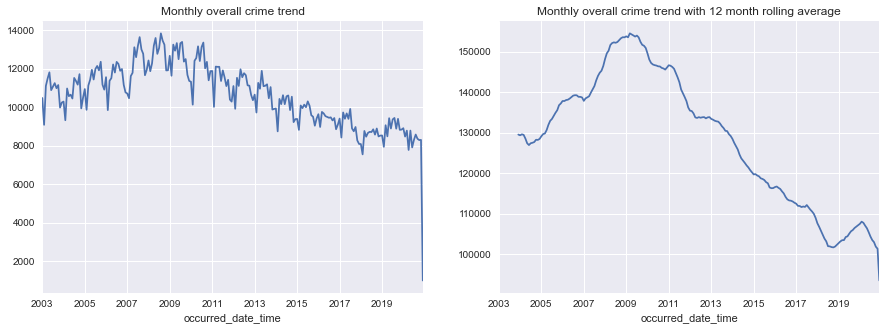

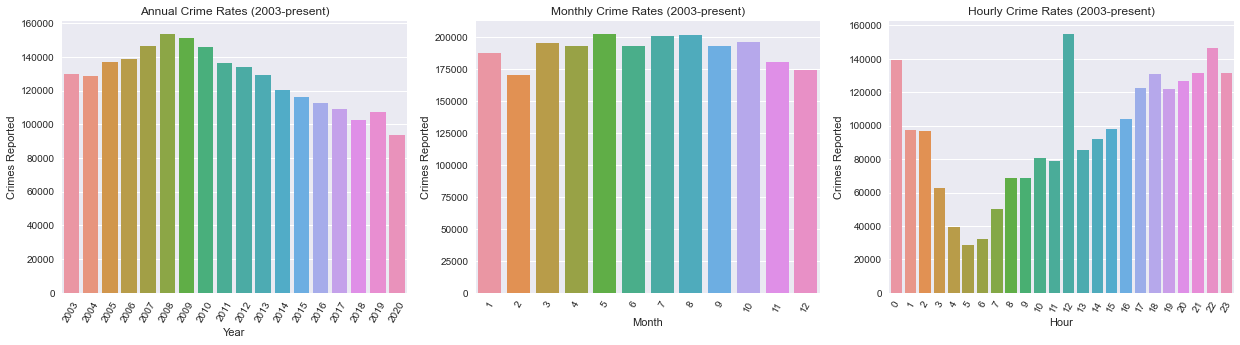

In [20]:
print("========================================")
print("Observing Austin crime trends since 2003")
print("========================================")
# Plotting overall trend on a monthly basis
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
df.resample("M").size().plot(
    title="Monthly overall crime trend",
    ax=axs[0],
)
# Monthly plot re-shown with a rolling average
df.resample("M").size().rolling(12).sum().plot(
    title="Monthly overall crime trend with 12 month rolling average",
    ax=axs[1],
)
plt.show()

# Visualizing overall yearly crime rate since 2003
crimes_per_year = df["year"].value_counts().sort_index()
fig, axs = plt.subplots(ncols=3, figsize=(21, 5))
g = sns.barplot(
    x=crimes_per_year.index,
    y=crimes_per_year.values,
    ax=axs[0],
)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
g.set(
    xlabel="Year",
    ylabel="Crimes Reported",
    title="Annual Crime Rates (2003-present)",
)
# Overall monthly crime rate
crimes_per_month = df["month"].value_counts().sort_index()
d = sns.barplot(
    x=crimes_per_month.index,
    y=crimes_per_month.values,
    ax=axs[1],
)
d.set_xticklabels(d.get_xticklabels(), rotation=60)
d.set(
    xlabel="Month",
    ylabel="Crimes Reported",
    title="Monthly Crime Rates (2003-present)",
)
# Overall hourly crime rates as well
crimes_per_hour = df["hour"].value_counts().sort_index()
e = sns.barplot(
    x=crimes_per_hour.index,
    y=crimes_per_hour.values,
    ax=axs[2],
)
e.set_xticklabels(e.get_xticklabels(), rotation=60)
e.set(
    xlabel="Hour",
    ylabel="Crimes Reported",
    title="Hourly Crime Rates (2003-present)",
)
plt.show()

#### Top 25 crime types 

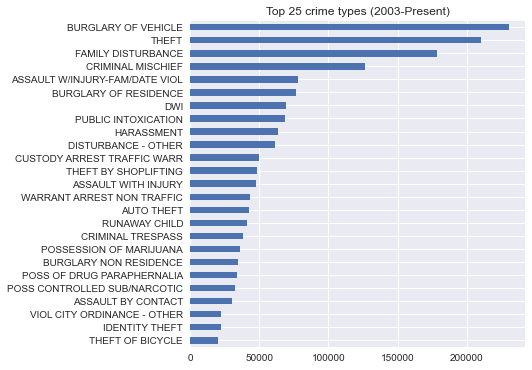

In [12]:
df.highest_offense_description.value_counts().head(25).sort_values().plot.barh(
    figsize=(6, 6), title="Top 25 crime types (2003-Present)"
)

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    205947
78753.0    178053
78701.0    167911
78758.0    158395
78704.0    153964
78745.0    150123
78702.0    136344
78744.0    125735
78723.0    117829
78752.0     84083
78748.0     67732
78759.0     65972
78751.0     63836
78757.0     57575
78705.0     56842
78721.0     47537
78749.0     40270
78724.0     37507
78727.0     35671
78703.0     35056
78731.0     28502
78746.0     28016
78729.0     25184
78750.0     23556
78754.0     22668
Name: zip_code, dtype: int64

----------------------------------


78741.0    0.090450
78753.0    0.078199
78701.0    0.073745
78758.0    0.069566
78704.0    0.067620
78745.0    0.065933
78702.0    0.059881
78744.0    0.055222
78723.0    0.051749
78752.0    0.036929
78748.0    0.029747
78759.0    0.028974
78751.0    0.028036
78757.0    0.025286
78705.0    0.024965
78721.0    0.020878
78749.0    0.017686
78724.0    0.016473
78727.0    0.015666
78703.0    0.015396
78731.0    0.012518
78746.0    0.012304
78729.0    0.011061
78750.0    0.010346
78754.0    0.009956
Name: zip_code, dtype: float64

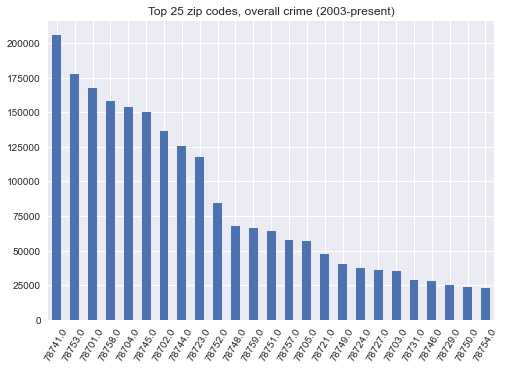

In [13]:
# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print("----------------------------------")
display(df.zip_code.value_counts(normalize=True).head(25))

# Visualizing the top 25 areas for crime
df.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 zip codes, overall crime (2003-present)"
)

#### Taking a closer look at particular areas... 

The next section will examine the zip codes 78701 (downtown), 78753, 78741, and 78745.

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78701 (downtown Austin)? 

PUBLIC INTOXICATION               17143
THEFT                             15708
BURGLARY OF VEHICLE                9232
WARRANT ARREST NON TRAFFIC         8968
DWI                                8299
ASSAULT WITH INJURY                7485
VIOL CITY ORDINANCE - OTHER        6187
POSS OF DRUG PARAPHERNALIA         6020
CRIMINAL MISCHIEF                  5778
CRIMINAL TRESPASS                  3896
POSSESSION OF MARIJUANA            3376
DISTURBANCE - OTHER                3339
CUSTODY ARREST TRAFFIC WARR        3001
POSS CONTROLLED SUB/NARCOTIC       2889
CAMPING IN PARK                    2791
VOCO - ALCOHOL  CONSUMPTION        2690
CRIMINAL TRESPASS/TRANSIENT        2575
ASSAULT BY CONTACT                 2563
THEFT OF BICYCLE                   2498
URINATING IN PUBLIC PLACE          2336
FAMILY DISTURBANCE                 2132
DOC FIGHTING                       2103
PROTECTIVE ORDER                   2101
ASSAULT W/INJURY-FAM/DATE VIOL     1723
Name: highest_offense_description, dtype

----------------------------------


PUBLIC INTOXICATION               0.102096
THEFT                             0.093550
BURGLARY OF VEHICLE               0.054982
WARRANT ARREST NON TRAFFIC        0.053409
DWI                               0.049425
ASSAULT WITH INJURY               0.044577
VIOL CITY ORDINANCE - OTHER       0.036847
POSS OF DRUG PARAPHERNALIA        0.035852
CRIMINAL MISCHIEF                 0.034411
CRIMINAL TRESPASS                 0.023203
POSSESSION OF MARIJUANA           0.020106
DISTURBANCE - OTHER               0.019886
CUSTODY ARREST TRAFFIC WARR       0.017873
POSS CONTROLLED SUB/NARCOTIC      0.017206
CAMPING IN PARK                   0.016622
VOCO - ALCOHOL  CONSUMPTION       0.016020
CRIMINAL TRESPASS/TRANSIENT       0.015336
ASSAULT BY CONTACT                0.015264
THEFT OF BICYCLE                  0.014877
URINATING IN PUBLIC PLACE         0.013912
FAMILY DISTURBANCE                0.012697
DOC FIGHTING                      0.012524
PROTECTIVE ORDER                  0.012513
ASSAULT W/I

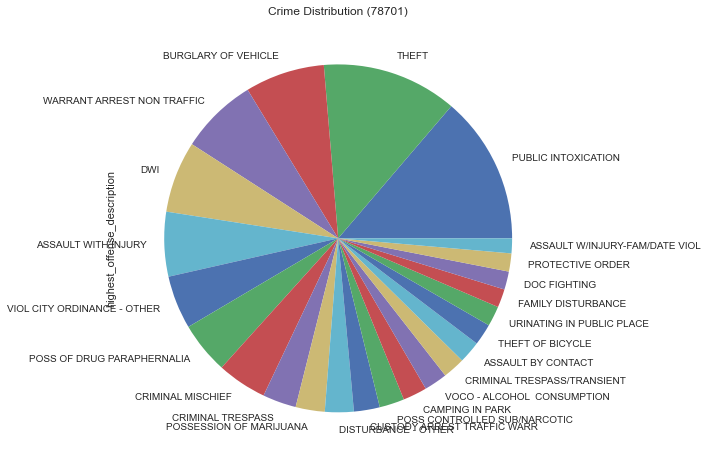

In [14]:
# Examining crime in the 78701 area
df_01 = df[df.zip_code == 78701]

# Create a dataframe for the top crime categories in the zipcode
df_01_off = df_01.highest_offense_description.value_counts().head(24)

# Display the different crime values & then as percentages
display(df_01_off)
print("----------------------------------")
display(df_01.highest_offense_description.value_counts(normalize=True).head(24))
df_01_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78701)")

<a id='q3'></a>
### C. Question 2. How is crime distributed in 78753? 

THEFT                             17063
BURGLARY OF VEHICLE               15914
FAMILY DISTURBANCE                14550
CRIMINAL MISCHIEF                  9399
THEFT BY SHOPLIFTING               7605
ASSAULT W/INJURY-FAM/DATE VIOL     7101
BURGLARY OF RESIDENCE              6043
DWI                                4968
DISTURBANCE - OTHER                4735
CUSTODY ARREST TRAFFIC WARR        4342
HARASSMENT                         4220
AUTO THEFT                         4168
POSS OF DRUG PARAPHERNALIA         3720
PUBLIC INTOXICATION                3362
ASSAULT WITH INJURY                3288
CRIMINAL TRESPASS                  3126
POSS CONTROLLED SUB/NARCOTIC       2963
RUNAWAY CHILD                      2915
WARRANT ARREST NON TRAFFIC         2793
POSSESSION OF MARIJUANA            2696
BURGLARY NON RESIDENCE             2486
VIOL CITY ORDINANCE - OTHER        1866
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.095831
BURGLARY OF VEHICLE               0.089378
FAMILY DISTURBANCE                0.081717
CRIMINAL MISCHIEF                 0.052788
THEFT BY SHOPLIFTING              0.042712
ASSAULT W/INJURY-FAM/DATE VIOL    0.039881
BURGLARY OF RESIDENCE             0.033939
DWI                               0.027902
DISTURBANCE - OTHER               0.026593
CUSTODY ARREST TRAFFIC WARR       0.024386
HARASSMENT                        0.023701
AUTO THEFT                        0.023409
POSS OF DRUG PARAPHERNALIA        0.020893
PUBLIC INTOXICATION               0.018882
ASSAULT WITH INJURY               0.018466
CRIMINAL TRESPASS                 0.017557
POSS CONTROLLED SUB/NARCOTIC      0.016641
RUNAWAY CHILD                     0.016372
WARRANT ARREST NON TRAFFIC        0.015686
POSSESSION OF MARIJUANA           0.015142
BURGLARY NON RESIDENCE            0.013962
VIOL CITY ORDINANCE - OTHER       0.010480
Name: highest_offense_description, dtype: float64

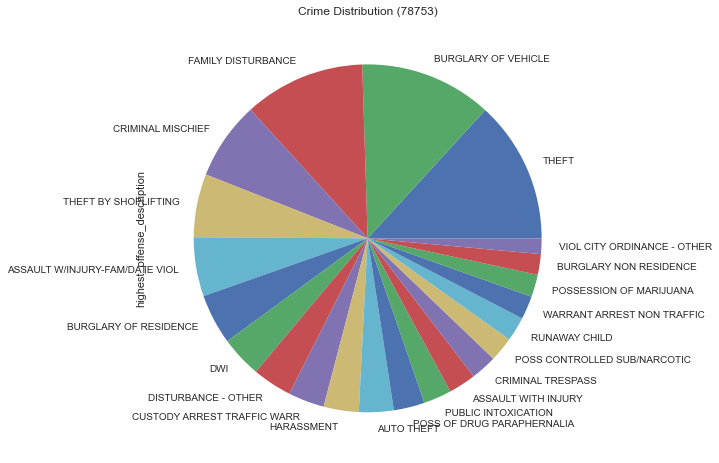

In [15]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_53_off)
print("----------------------------------")
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))
df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q4'></a>
### D. Question 4. How is crime distributed in 78741 (E Riverside/Oltorf)? 

FAMILY DISTURBANCE                20240
BURGLARY OF VEHICLE               19752
THEFT                             15535
CRIMINAL MISCHIEF                 10996
ASSAULT W/INJURY-FAM/DATE VIOL     9596
BURGLARY OF RESIDENCE              8854
PUBLIC INTOXICATION                6374
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5634
HARASSMENT                         5474
DISTURBANCE - OTHER                5141
AUTO THEFT                         4580
ASSAULT WITH INJURY                4521
CRIMINAL TRESPASS                  3891
POSS CONTROLLED SUB/NARCOTIC       3843
POSSESSION OF MARIJUANA            3791
THEFT BY SHOPLIFTING               3569
POSS OF DRUG PARAPHERNALIA         3530
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2784
VIOL CITY ORDINANCE - OTHER        2196
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098278
BURGLARY OF VEHICLE               0.095908
THEFT                             0.075432
CRIMINAL MISCHIEF                 0.053392
ASSAULT W/INJURY-FAM/DATE VIOL    0.046595
BURGLARY OF RESIDENCE             0.042992
PUBLIC INTOXICATION               0.030950
CUSTODY ARREST TRAFFIC WARR       0.029187
DWI                               0.027357
HARASSMENT                        0.026580
DISTURBANCE - OTHER               0.024963
AUTO THEFT                        0.022239
ASSAULT WITH INJURY               0.021952
CRIMINAL TRESPASS                 0.018893
POSS CONTROLLED SUB/NARCOTIC      0.018660
POSSESSION OF MARIJUANA           0.018408
THEFT BY SHOPLIFTING              0.017330
POSS OF DRUG PARAPHERNALIA        0.017140
WARRANT ARREST NON TRAFFIC        0.016742
RUNAWAY CHILD                     0.013518
VIOL CITY ORDINANCE - OTHER       0.010663
Name: highest_offense_description, dtype: float64

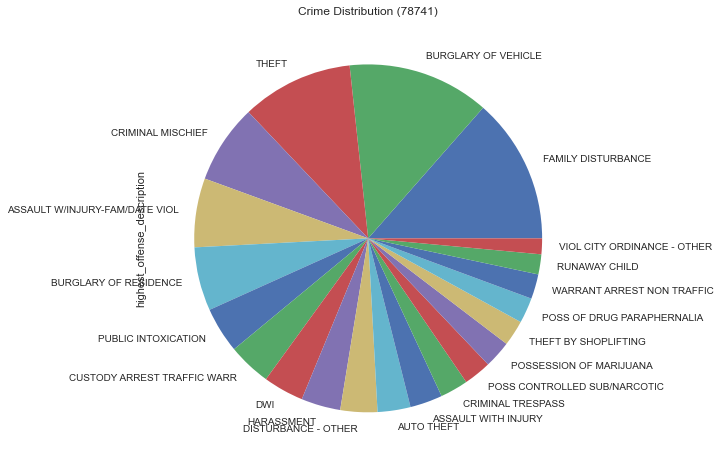

In [16]:
# Examining crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages
display(df_41_off)
print("----------------------------------")
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))
df_41_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78741)")

<a id='q5'></a>
### E. Question 5. How is crime distributed in 78745 (far south Austin)?

FAMILY DISTURBANCE                14830
BURGLARY OF VEHICLE               14727
THEFT                             13499
CRIMINAL MISCHIEF                  8466
BURGLARY OF RESIDENCE              5861
ASSAULT W/INJURY-FAM/DATE VIOL     5731
HARASSMENT                         5109
DISTURBANCE - OTHER                4493
DWI                                4395
PUBLIC INTOXICATION                3990
CUSTODY ARREST TRAFFIC WARR        3244
BURGLARY NON RESIDENCE             2916
AUTO THEFT                         2826
ASSAULT WITH INJURY                2653
RUNAWAY CHILD                      2590
POSSESSION OF MARIJUANA            2586
WARRANT ARREST NON TRAFFIC         2108
POSS CONTROLLED SUB/NARCOTIC       2010
THEFT BY SHOPLIFTING               1963
CRIMINAL TRESPASS                  1942
IDENTITY THEFT                     1561
POSS OF DRUG PARAPHERNALIA         1515
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098786
BURGLARY OF VEHICLE               0.098100
THEFT                             0.089920
CRIMINAL MISCHIEF                 0.056394
BURGLARY OF RESIDENCE             0.039041
ASSAULT W/INJURY-FAM/DATE VIOL    0.038175
HARASSMENT                        0.034032
DISTURBANCE - OTHER               0.029929
DWI                               0.029276
PUBLIC INTOXICATION               0.026578
CUSTODY ARREST TRAFFIC WARR       0.021609
BURGLARY NON RESIDENCE            0.019424
AUTO THEFT                        0.018825
ASSAULT WITH INJURY               0.017672
RUNAWAY CHILD                     0.017253
POSSESSION OF MARIJUANA           0.017226
WARRANT ARREST NON TRAFFIC        0.014042
POSS CONTROLLED SUB/NARCOTIC      0.013389
THEFT BY SHOPLIFTING              0.013076
CRIMINAL TRESPASS                 0.012936
IDENTITY THEFT                    0.010398
POSS OF DRUG PARAPHERNALIA        0.010092
Name: highest_offense_description, dtype: float64

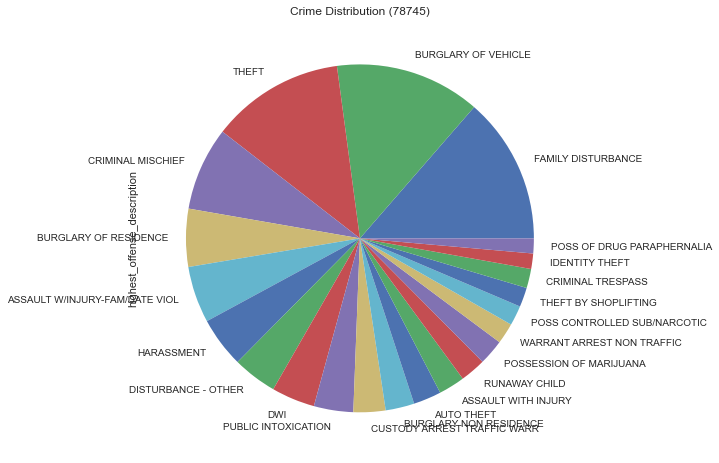

In [17]:
# Examining crime in the 78745 area
df_45 = df[df.zip_code == 78745]

# Create a dataframe for the top 10 crime categories in the zipcode
df_45_off = df_45.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_45_off)
print("----------------------------------")
display(df_45.highest_offense_description.value_counts(normalize=True).head(22))
df_45_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78745)")

<a id='q6'></a>
### F. Question 6. How is crime distributed in 78705 (UT campus area)?

BURGLARY OF VEHICLE               8591
THEFT                             5588
CRIMINAL MISCHIEF                 4945
THEFT OF BICYCLE                  3455
PUBLIC INTOXICATION               2625
BURGLARY OF RESIDENCE             2115
WARRANT ARREST NON TRAFFIC        1548
CRIMINAL TRESPASS                 1336
AUTO THEFT                        1295
ASSAULT WITH INJURY               1243
DWI                               1217
HARASSMENT                        1205
FAMILY DISTURBANCE                1179
DISTURBANCE - OTHER               1110
BURGLARY NON RESIDENCE             872
CRIMINAL TRESPASS/TRANSIENT        868
VIOL CITY ORDINANCE - OTHER        791
CUSTODY ARREST TRAFFIC WARR        783
GRAFFITI                           775
ASSAULT W/INJURY-FAM/DATE VIOL     688
POSSESSION OF MARIJUANA            656
ASSAULT BY CONTACT                 612
Name: highest_offense_description, dtype: int64

----------------------------------


BURGLARY OF VEHICLE               0.151138
THEFT                             0.098308
CRIMINAL MISCHIEF                 0.086996
THEFT OF BICYCLE                  0.060783
PUBLIC INTOXICATION               0.046181
BURGLARY OF RESIDENCE             0.037208
WARRANT ARREST NON TRAFFIC        0.027233
CRIMINAL TRESPASS                 0.023504
AUTO THEFT                        0.022782
ASSAULT WITH INJURY               0.021868
DWI                               0.021410
HARASSMENT                        0.021199
FAMILY DISTURBANCE                0.020742
DISTURBANCE - OTHER               0.019528
BURGLARY NON RESIDENCE            0.015341
CRIMINAL TRESPASS/TRANSIENT       0.015270
VIOL CITY ORDINANCE - OTHER       0.013916
CUSTODY ARREST TRAFFIC WARR       0.013775
GRAFFITI                          0.013634
ASSAULT W/INJURY-FAM/DATE VIOL    0.012104
POSSESSION OF MARIJUANA           0.011541
ASSAULT BY CONTACT                0.010767
Name: highest_offense_description, dtype: float64

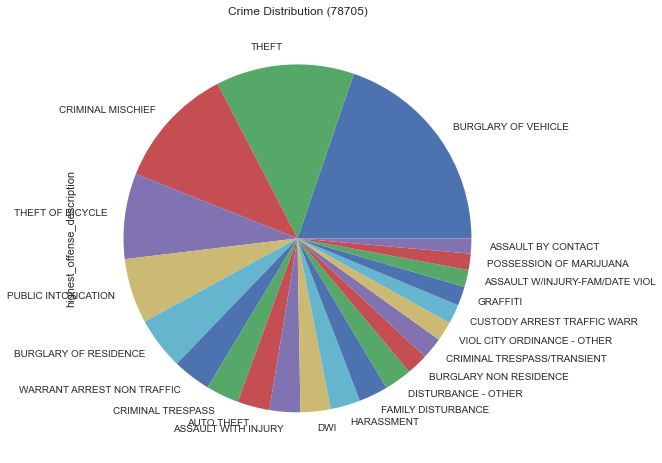

In [18]:
# Examining crime in the 78705 area
df_05 = df[df.zip_code == 78705]

# Create a dataframe for the top 10 crime categories in the zipcode
df_05_off = df_05.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_05_off)
print("----------------------------------")
display(df_05.highest_offense_description.value_counts(normalize=True).head(22))
df_05_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78705)")

<a id='q7'></a>
### H. Question 7. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

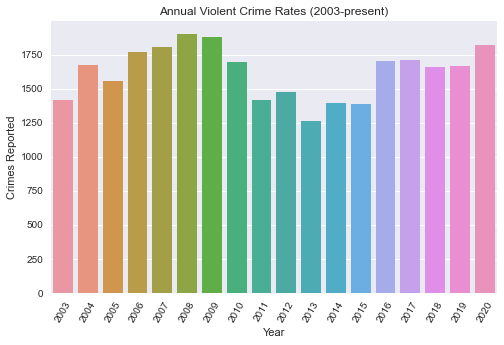

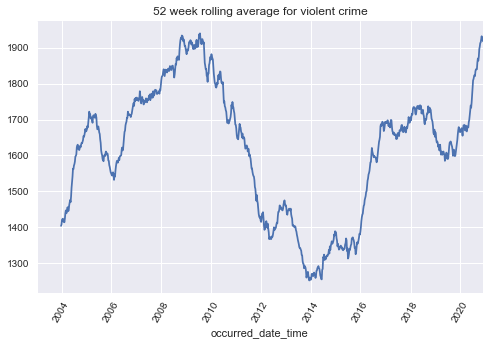

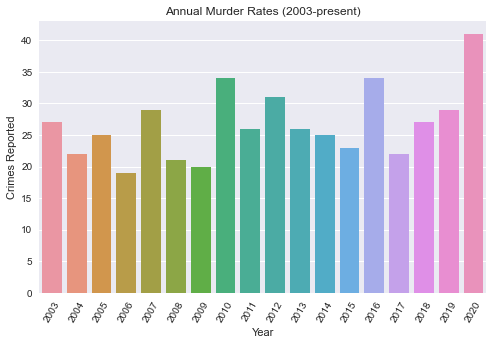

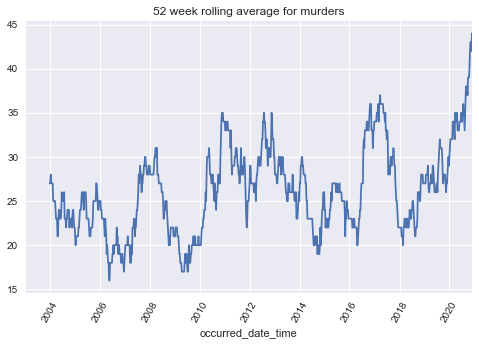

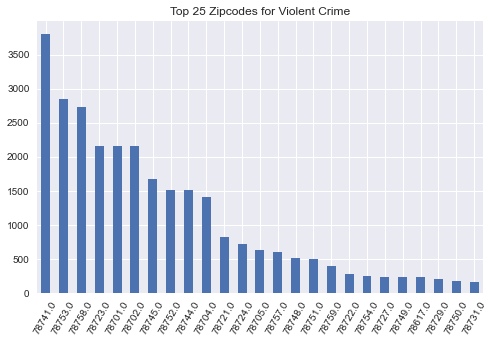

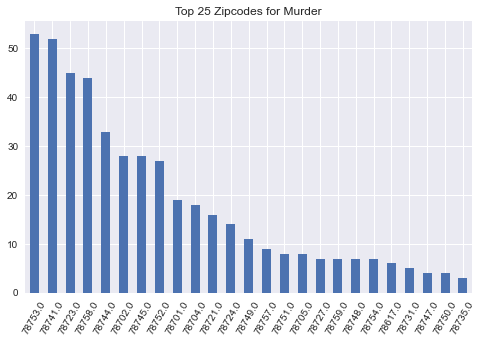

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,,
78610.0,1,0,0,0,0
78613.0,14,11,0,1,6
78617.0,120,62,0,6,36
78621.0,1,0,0,0,0
78634.0,1,0,0,0,0
78652.0,2,0,0,0,0
78653.0,10,3,0,1,1
78660.0,66,27,0,2,18
78664.0,3,0,0,0,0


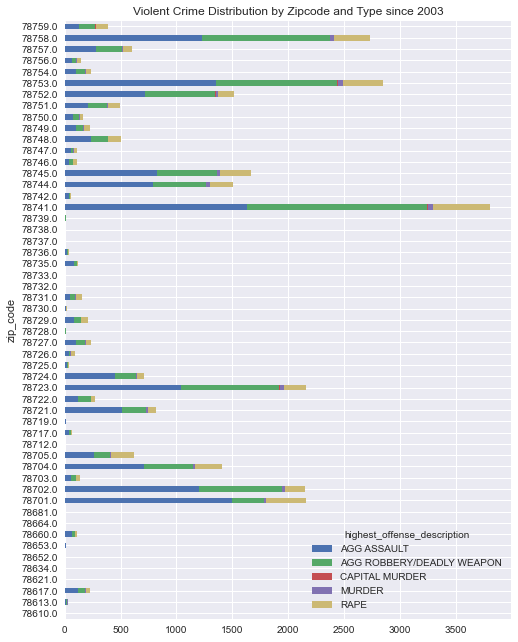

----------------------------------


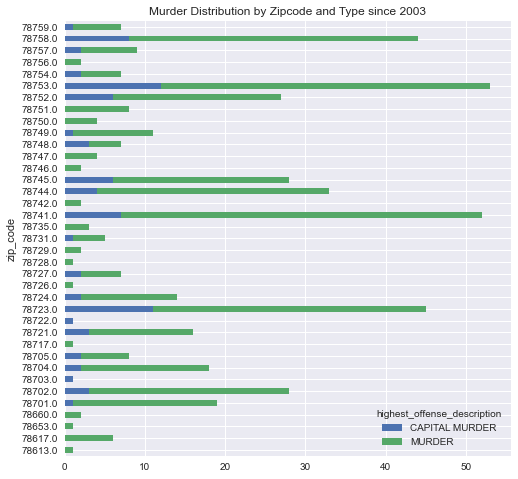

In [19]:
# Creating an overall and separate dataframes for violent crime
df_viol = df.query(
    'highest_offense_description == ["AGG ASSAULT", "AGG ROBBERY/DEADLY WEAPON", "CAPITAL MURDER", "MURDER", "RAPE"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == "MURDER"]
df_mur_cap = df[df.highest_offense_description == "CAPITAL MURDER"]
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_agg_robbery = df[df.highest_offense_description == "AGG ROBBERY/DEADLY WEAPON"]
df_rape = df[df.highest_offense_description == "RAPE"]

# Creating yearly dataframes
# Annual overall crime
df_17 = df[df.year == 2017]
df_18 = df[df.year == 2018]
df_19 = df[df.year == 2019]
df_20 = df[df.year == 2020]

# Annual violent crime
df_viol_17 = df_viol[df_viol.year == 2017]
df_viol_18 = df_viol[df_viol.year == 2018]
df_viol_19 = df_viol[df_viol.year == 2019]
df_viol_20 = df_viol[df_viol.year == 2020]

# Annual murders
df_viol_mur_17 = df_viol_mur[df_viol_mur.year == 2017]
df_viol_mur_18 = df_viol_mur[df_viol_mur.year == 2018]
df_viol_mur_19 = df_viol_mur[df_viol_mur.year == 2019]
df_viol_mur_20 = df_viol_mur[df_viol_mur.year == 2020]

# Visualizing overall violent crime trend
# viol_per_year = df_viol["year"].value_counts().sort_index()
# viol_per_year.plot.bar(
#    rot=60, figsize=(10, 5), title="Annual violent crime counts (2003-present)"
# )
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(df_viol.resample("Q").size())
# plt.title("Monthly trend (2003-Present)")
# plt.show()

# Visualizing overall yearly violent crime rate since 2003
crimes_per_year = df_viol["year"].value_counts().sort_index()
plt.figure(figsize=(8, 5))
g = sns.barplot(x=crimes_per_year.index, y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
g.set(
    xlabel="Year",
    ylabel="Crimes Reported",
    title="Annual Violent Crime Rates (2003-present)",
)
plt.show()

# As rolling average
df_viol.resample("W").size().rolling(52).sum().plot(
    rot=60, figsize=(8, 5), title="52 week rolling average for violent crime"
)
plt.show()

# Visualizing overall murders
# mur_per_year = df_viol_mur.year.value_counts().sort_index()
# mur_per_year.plot.bar(
#    rot=60, figsize=(10, 5), title="Annual murder counts (2003-present)"
# )
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(df_viol_mur.resample("Q").size())
# plt.title("Monthly trend (2003-Present)")
# plt.show()

# Visualizing overall yearly murder rates since 2003
crimes_per_year = df_viol_mur["year"].value_counts().sort_index()
plt.figure(figsize=(8, 5))
g = sns.barplot(x=crimes_per_year.index, y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
g.set(
    xlabel="Year", ylabel="Crimes Reported", title="Annual Murder Rates (2003-present)"
)
plt.show()

# As rolling average
df_viol_mur.resample("W").size().rolling(52).sum().plot(
    rot=60, figsize=(8, 5), title="52 week rolling average for murders"
)
plt.show()

print("==============================================================================")
print("==============================================================================")

# Visualizing yearly violent crime trends for 2017 - 2020
# Overall violent crime by Zipcode
# display(df_viol.zip_code.value_counts(normalize=True).head(25))
df_viol.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Violent Crime", rot=60, figsize=(8, 5)
)
plt.show()

# display(df_viol_mur.zip_code.value_counts(normalize=True).head(25))
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Murder", rot=60, figsize=(8, 5)
)
plt.show()

# Calculating and visualizing frequency rate of violent crimes by zipcode
viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
display(viol_freq)
viol_freq.plot.barh(
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    figsize=(8, 11),
    stacked=True,
)
plt.show()

print("----------------------------------")

# Calculating and visualizing frequency rate of murders by zipcode
mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)
mur_freq.plot.barh(
    figsize=(8, 8),
    title="Murder Distribution by Zipcode and Type since 2003",
    stacked=True,
)
plt.show()

Because crime began increasing again, after 2018, I wanted to take a closer look at the trend around that year. Here I broke down the overall and violent crime dataframes into annual parts, then displaying their rolling averages for a comparison. Once again, implementation of a rolling average was done just to make the visualizations easier to read.

Overalln crime 2017-present


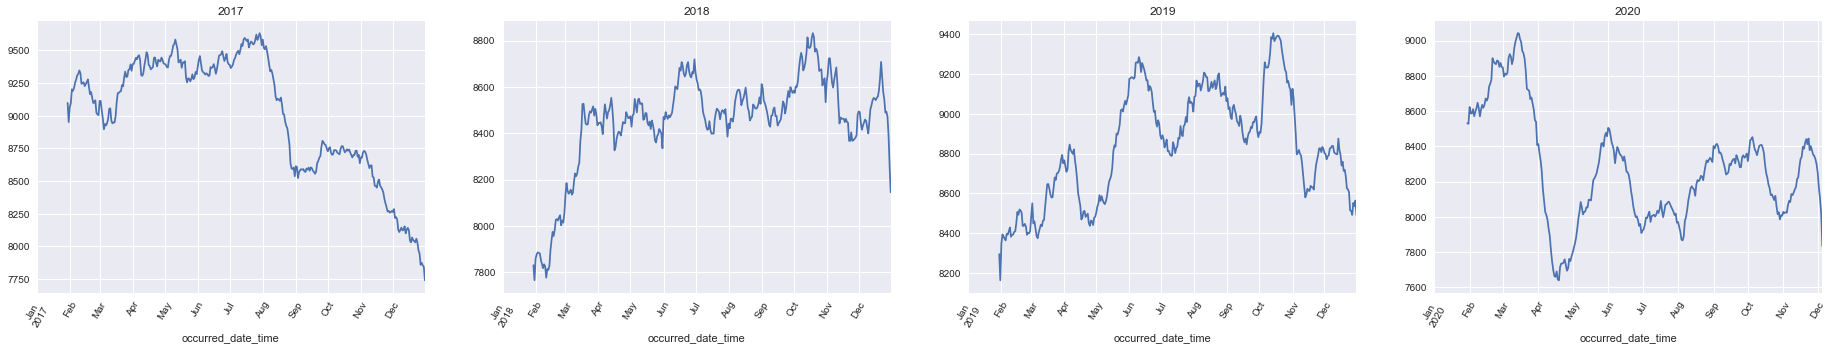

Violent crime 2017-present


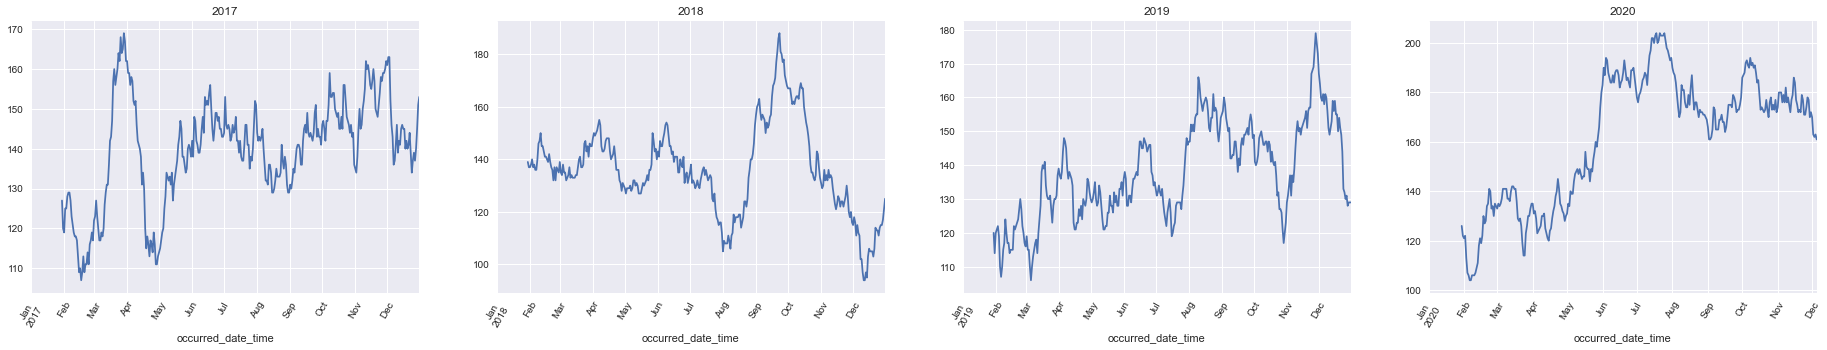

In [35]:
print("===========================")
print("Overalln crime 2017-present")
print("===========================")
fig, axs = plt.subplots(ncols=4, figsize=(32, 5))
df_17.resample("D").size().rolling(30).sum().plot(
    # figsize=(8, 5),
    rot=60,
    title="2017",
    ax=axs[0],
)
df_18.resample("D").size().rolling(30).sum().plot(
    # figsize=(8, 5),
    rot=60,
    title="2018",
    ax=axs[1],
)
df_19.resample("D").size().rolling(30).sum().plot(
    # figsize=(8, 5),
    rot=60,
    title="2019",
    ax=axs[2],
)
df_20.resample("D").size().rolling(30).sum().plot(
    # figsize=(8, 5),
    rot=60,
    title="2020",
    ax=axs[3],
)
plt.show()


print("==========================")
print("Violent crime 2017-present")
print("==========================")
fig, axs = plt.subplots(ncols=4, figsize=(32, 5))
df_viol_17.resample("D").size().rolling(30).sum().plot(
    # figsize=(8, 5),
    rot=60,
    title="2017",
    ax=axs[0],
)
df_viol_18.resample("D").size().rolling(30).sum().plot(
    # figsize=(8, 5),
    rot=60,
    title="2018",
    ax=axs[1],
)
df_viol_19.resample("D").size().rolling(30).sum().plot(
    # figsize=(8, 5),
    rot=60,
    title="2019",
    ax=axs[2],
)
df_viol_20.resample("D").size().rolling(30).sum().plot(
    # figsize=(8, 5),
    rot=60,
    title="2020",
    ax=axs[3],
)
plt.show()

#### Distribution of violent crime and murders across council districts, APD Districts, and APD sectors 

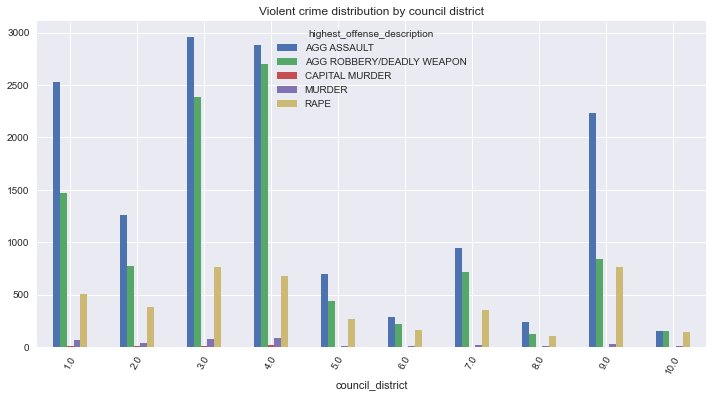

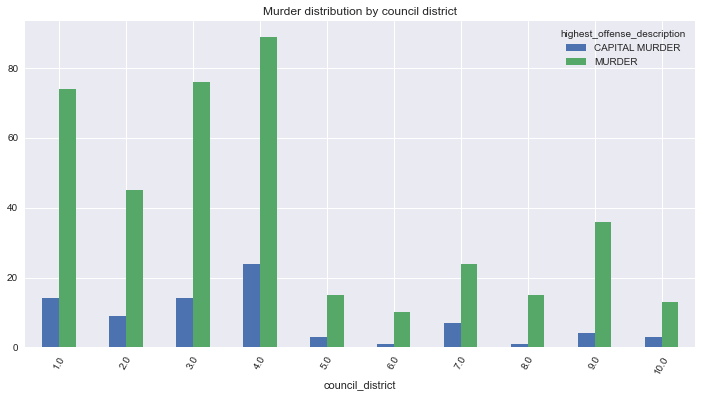

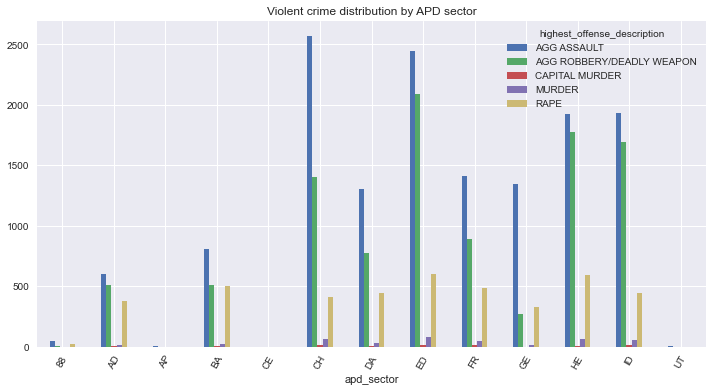

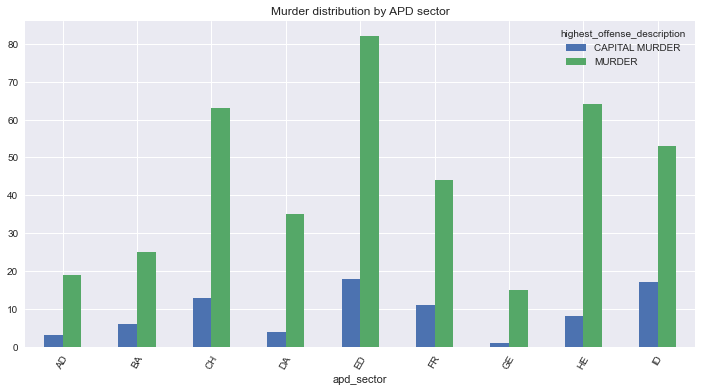

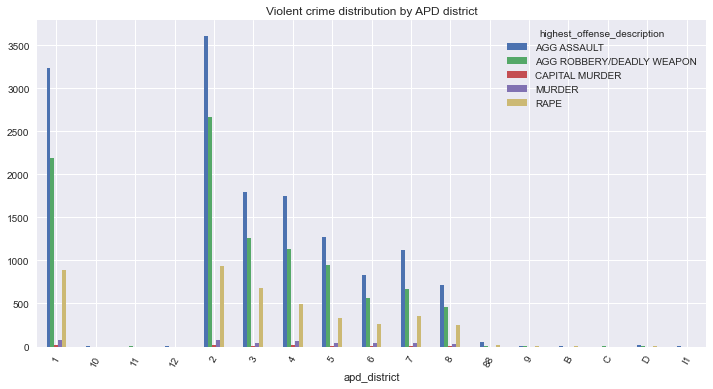

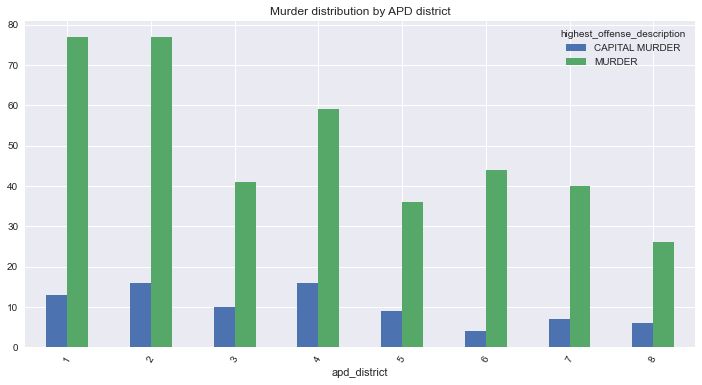

In [24]:
pd.crosstab(df_viol.council_district, df_viol.highest_offense_description).plot.bar(
    # stacked=True,
    figsize=(12, 6),
    rot=60,
    title="Violent crime distribution by council district",
)
plt.show()

pd.crosstab(
    df_viol_mur.council_district, df_viol_mur.highest_offense_description
).plot.bar(
    figsize=(12, 6),
    rot=60,
    # fontsize=12,
    title="Murder distribution by council district",
)
plt.show()

pd.crosstab(df_viol.apd_sector, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6),
    # stacked=True,
    rot=60,
    # fontsize=12,
    title="Violent crime distribution by APD sector",
)
plt.show()

pd.crosstab(df_viol_mur.apd_sector, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6),
    rot=60,
    # fontsize=12,
    title="Murder distribution by APD sector",
)
plt.show()

pd.crosstab(df_viol.apd_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6),
    # stacked=True,
    rot=60,
    # fontsize=12,
    title="Violent crime distribution by APD district",
)
plt.show()

pd.crosstab(df_viol_mur.apd_district, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6),
    rot=60,
    # fontsize=12,
    title="Murder distribution by APD district",
)
plt.show()

#### Violent crime and murder distribution by location type

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
location_type,,,,,
ABANDONED/CONDEMNED STRUCTURE,13,7,0,1,4
AMUSEMENT PARK,0,1,0,0,0
ARENA / STADIUM / FAIRGROUNDS / COLISEUM,2,0,0,0,0
ATM SEPARATE FROM BANK,1,2,0,0,0
AUTO DEALERSHIP NEW / USED,10,2,0,0,1
BANKS / SAVINGS & LOAN,5,133,0,1,1
BAR / NIGHT CLUB,651,45,2,7,76
CAMP / CAMPGROUND,20,2,0,0,2
CHURCH / SYNAGOGUE / TEMPLE / MOSQUE,20,5,1,0,7


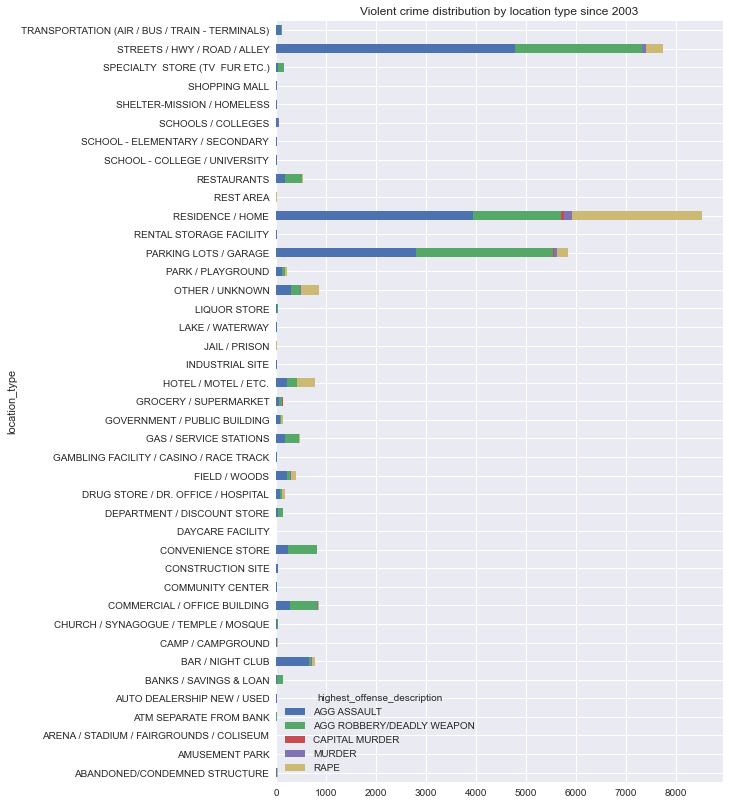

----------------------------------


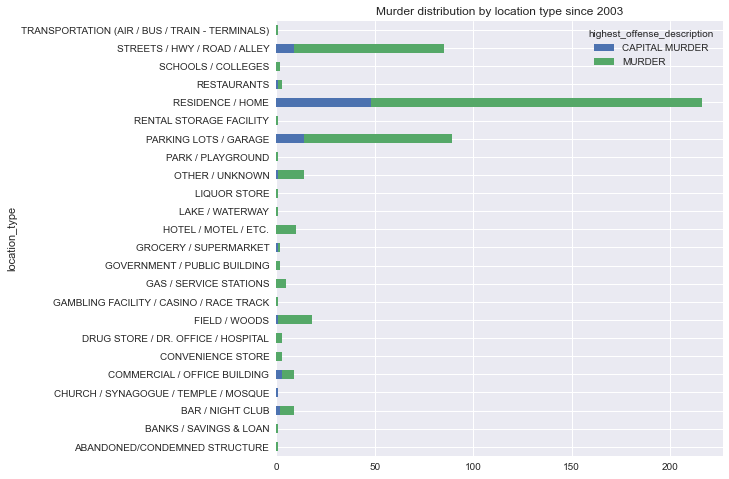

In [25]:
viol_loc = pd.crosstab(df_viol.location_type, df_viol.highest_offense_description)
display(viol_loc)

mur_loc = pd.crosstab(
    df_viol_mur.location_type, df_viol_mur.highest_offense_description
)

viol_loc.plot.barh(
    figsize=(8, 14),
    stacked=True,
    title="Violent crime distribution by location type since 2003",
)
plt.show()

print("----------------------------------")

mur_loc.plot.barh(
    figsize=(8, 8),
    stacked=True,
    title="Murder distribution by location type since 2003",
)
plt.show()

<a id='q9'></a>
### I. Question 9. How does violent crime appear on the map?

** Note: Rape incidents provide no location coordinates therefore cannot be shown on a map. **

#### Aggravated assault 

In [26]:
# Aggravated assault as a heatmap
agg_asslt_coords_heat = df_agg_asslt[
    (df_agg_asslt["latitude"].isnull() == False)
    & (df_agg_asslt["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(agg_asslt_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="agg_asslt_heatmap.html")

k

#### Armed robbery 

In [27]:
# Aggravated robbery as a heatmap
agg_robbery_coords_heat = df_agg_robbery[
    (df_agg_robbery["latitude"].isnull() == False)
    & (df_agg_robbery["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(
        agg_robbery_coords_heat[["latitude", "longitude"]].values, radius=15
    )
)

k.save(outfile="agg_robbery_heatmap.html")

k

<a id='q8'></a>
#### Murder  

In [28]:
# As a heatmap
mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="mur_heatmap.html")

k

<a id='q10'></a>
### J. Question 10. Are there any addresses where violent crime and murder occurs frequently?

In [29]:
# Show addresses with 50 or more reported violent crimes
df_viol.address.value_counts().head(13)

500 E 7TH ST                82
9515 N LAMAR BLVD           66
1700 BURTON DR              62
6409 SPRINGDALE RD          59
00 BLOCK UNKNOWN            59
9601 MIDDLE FISKVILLE RD    58
900 BLOCK E 32ND ST         54
1030 NORWOOD PARK BLVD      53
1071 CLAYTON LN             53
9200 NORTH PLZ              53
2237 E RIVERSIDE DR         51
1137 GUNTER ST              51
1124 RUTLAND DR             50
Name: address, dtype: int64

In [30]:
# Show addresses with 2 or more reported murders
df_viol_mur.address.value_counts().head(31)

4700 E RIVERSIDE DR          3
6409 SPRINGDALE RD           3
6407 SPRINGDALE RD           3
8610 N LAMAR BLVD            3
8800 N IH 35 SVRD SB         3
601 E 15TH ST                2
6600 ED BLUESTEIN BLVD SB    2
2915 S IH 35 SVRD NB         2
2508 E RIVERSIDE DR          2
1137 GUNTER ST               2
1711 RUTLAND DR              2
6118 FAIRWAY ST              2
8912 N LAMAR BLVD            2
8225 SAM RAYBURN DR          2
1050 SPRINGDALE RD           2
833 FAIRFIELD DR             2
9601 MIDDLE FISKVILLE RD     2
201 W 5TH ST                 2
2400 WICKERSHAM LN           2
2101 ELMONT DR               2
2501 ANKEN DR                2
2713 S CONGRESS AVE          2
10610 MORADO CIR             2
10503 N LAMAR BLVD           2
605 MASTERSON PASS           2
744 W WILLIAM CANNON DR      2
7000 DECKER LN               2
815 W SLAUGHTER LN           2
9200 NORTH PLZ               2
9220 N IH 35 SVRD SB         2
9010 GALEWOOD DR             2
Name: address, dtype: int64

## IV. Summary 

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.05%. This is a significant 1.23 percentage points higher than the number 2 area 78753 which hosts 7.82% of overall crime.

As we can see, violent crime spiked tremendously after 2018, and especially for 2020 so far.

Years 2010 and 2016 had the most number of murders. However, and alarmingly, as of 11/23/2020, we've now had more murders this year than any other since 2003. Presently, the murder count for 2020 is at 39!!

So, you're most likely to get murdered in July, between 1 and 2am, in the 78753 zip code, with 78741 coming in as a very strong alternate. Good to know!

In [31]:
df_clean = df.copy()
df_clean.to_csv("df_clean.csv")

df_17.to_csv("df_17.csv")
df_18.to_csv("df_18.csv")
df_19.to_csv("df_19.csv")
df_20.to_csv("df_20.csv")

df_viol_17.to_csv("df_viol_17.csv")
df_viol_18.to_csv("df_viol_18.csv")
df_viol_19.to_csv("df_viol_19.csv")
df_viol_20.to_csv("df_viol_20.csv")

df_viol_mur_17.to_csv("df_viol_mur_17.csv")
df_viol_mur_18.to_csv("df_viol_mur_18.csv")
df_viol_mur_19.to_csv("df_viol_mur_19.csv")
df_viol_mur_20.to_csv("df_viol_mur_20.csv")

df_viol.to_csv("df_viol.csv")
df_viol_mur.to_csv("df_viol_mur.csv")

df_01.to_csv("df_01.csv")
df_53.to_csv("df_53.csv")
df_41.to_csv("df_41.csv")
df_45.to_csv("df_45.csv")
df_05.to_csv("df_05.csv")